In [1]:
#get_ipython().magic('matplotlib notebook')
#get_ipython().magic('matplotlib inline')

#import os
import time
#import datetime as dt
import numpy as np
#from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader
#import stock_data_preprocessing_x

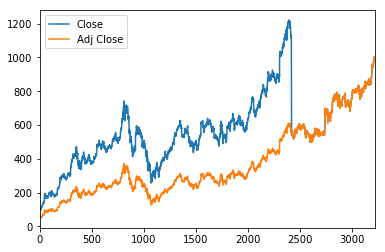

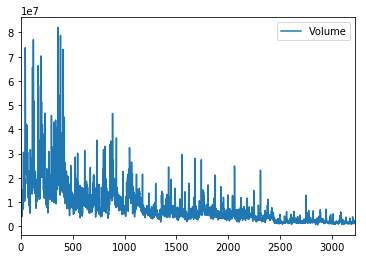

In [2]:
# [2]:

###############################################################################
#load Google stock data
#start = dt.datetime(1995,1,1)
#end   = dt.date.today()
#data = pandas_datareader.data.DataReader('GOOG','yahoo',start,end)
data = pd.read_csv('googl.csv')
#data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]
#data = data.set_index(['Date'])
data.head()
data.shape

data.plot(y=['Close', 'Adj Close'])
data.plot(y=['Volume'])
plt.show()

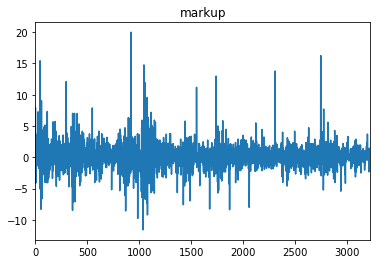

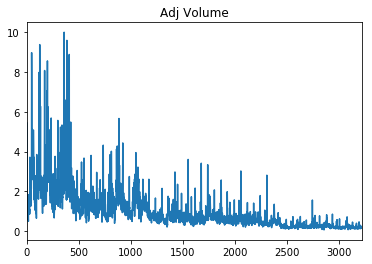

In [3]:
# [3]:
###############################################################################
#pd.DataFrame(data['Adj Close'].cumsum()).plot()

# calculate markup of adj close, this will be the predict target y
# markup = (today price - last day price) / last day price * 100
# the first day markup=0
aryMarkup = np.zeros(shape=(len(data),1))
aryMarkup.shape
data.shape

preRow = None
for i, row in data.iterrows():
#    print(i,end='\r')
    if( preRow is None ):
        preRow = row
        continue
#    print(i)
#    aryMarkup[i] = 1
#    print(row['Adj Close'])
#    print(preRow['Adj Close'])
    aryMarkup[i] = (row['Adj Close'] - preRow['Adj Close']) / preRow['Adj Close']
    preRow = row

data['markup'] = aryMarkup*100
#data['markup'].plot(figsize=(15,6))

max_volume = data['Volume'].max()
data['Adj Volume'] = data['Volume'] / max_volume * 10

# [4]:
data_n = pd.DataFrame(data[['Adj Volume', 'markup']])
data_n.shape

data_n['markup'].plot()
plt.title('markup')
plt.show()

data_n['Adj Volume'].plot()
plt.title('Adj Volume')
plt.show()

#stock_data_preprocessing.stock_plot((data_n,))
#stock_data_preprocessing.stock_plot(data_n)

In [14]:
###############################################################################
#
# make training and test data set
#
# x_train.shape = (samples, seq_steps, input_features)
# y_train.shape = (samples,)
#
# x_test.shape = (samples, seq_steps, input_features)
# y_test.shape = (samples,)

# [5]:


# training data
prediction_time = 1 # predict the markup of the prediction_time day
testdatasize = 300
seq_steps = 20
testdatacut = testdatasize + seq_steps + 1

x_train = data_n[1 : -testdatacut].as_matrix()
y_train = data_n[1+prediction_time : -testdatacut+prediction_time]['markup'].as_matrix()
#y_train = data_n[prediction_time:-testdatacut  ]['Adj Close'].as_matrix()
#y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()
x_train.shape
y_train.shape

# test data
x_test = data_n[-testdatacut : -prediction_time].as_matrix()
y_test = data_n[-testdatacut+prediction_time :]['markup'].as_matrix()
#y_test = data_n[prediction_time-testdatacut:  ]['Adj Close'].as_matrix()
#y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()
x_test.shape
y_test.shape

# # unroll it

# [6]:


def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length + 1):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,seq_steps)
x_test  = unroll(x_test,seq_steps)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]
#y_train = y_train[-x_train.shape[0]:]
#y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

print()
print("x_train[0:5]")
print(x_train[0:5])
print("y_train[0:5]", y_train[0:5])

x_train (2881, 20, 2)
y_train (2881,)
x_test (301, 20, 2)
y_test (301,)

x_train[0:5]
[[[ 2.7795489   7.94299603]
  [ 2.22225874  1.00636776]
  [ 1.8560068  -4.14076382]
  [ 1.11849993  1.07752728]
  [ 0.86362812  1.80188492]
  [ 0.75613108 -1.63099083]
  [ 0.63257826 -3.9001393 ]
  [ 0.59862862  0.35290622]
  [ 1.1123649  -2.07092102]
  [ 1.84034054  1.2568566 ]
  [ 0.62718576 -1.47768744]
  [ 0.71179814  1.56984148]
  [ 0.60688171  0.70880616]
  [ 0.49441821  0.00977516]
  [ 1.05887809  2.95180817]
  [ 0.9548381   2.06019168]
  [ 1.31816859  3.7116299 ]
  [ 1.30406044  0.45744326]
  [ 1.12795812  1.75892678]
  [ 1.15305821  3.08852898]]

 [[ 2.22225874  1.00636776]
  [ 1.8560068  -4.14076382]
  [ 1.11849993  1.07752728]
  [ 0.86362812  1.80188492]
  [ 0.75613108 -1.63099083]
  [ 0.63257826 -3.9001393 ]
  [ 0.59862862  0.35290622]
  [ 1.1123649  -2.07092102]
  [ 1.84034054  1.2568566 ]
  [ 0.62718576 -1.47768744]
  [ 0.71179814  1.56984148]
  [ 0.60688171  0.70880616]
  [ 0.49441821  

In [5]:
###############################################################################
# (with Python 3.5.3, Tensorflow 1.2, Keras 2.0.4, win10 64bit)

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=128,
    return_sequences=True))
#model.add(Dropout(0.15))

model.add(LSTM(
    128,
    return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(20))
model.add(Dense(output_dim=1))
#model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

Using TensorFlow backend.
C:\Develop\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Develop\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 2), return_sequences=True, units=128)`


compilation time : 0.06968522071838379


C:\Develop\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


C:\Develop\Anaconda3\envs\py35\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2592 samples, validate on 289 samples
Epoch 1/25
2592/2592 [==============================] - 10s - loss: 4.1931 - val_loss: 3.3277
Epoch 2/25
2592/2592 [==============================] - 2s - loss: 4.1807 - val_loss: 3.3406
Epoch 3/25
2592/2592 [==============================] - 2s - loss: 4.1723 - val_loss: 3.3396
Epoch 4/25
2592/2592 [==============================] - 2s - loss: 4.1804 - val_loss: 3.3479
Epoch 5/25
2592/2592 [==============================] - 2s - loss: 4.1683 - val_loss: 3.3308
Epoch 6/25
2592/2592 [==============================] - 2s - loss: 4.1629 - val_loss: 3.3700
Epoch 7/25
2592/2592 [==============================] - 2s - loss: 4.1652 - val_loss: 3.3344
Epoch 8/25
2592/2592 [==============================] - 2s - loss: 4.1633 - val_loss: 3.3259
Epoch 9/25
2592/2592 [==============================] - 2s - loss: 4.1622 - val_loss: 3.3225
Epoch 10/25
2592/2592 [==============================] - 2s - loss: 4.1606 - val_loss: 3.3384
Epoch 11/25
2592/2592

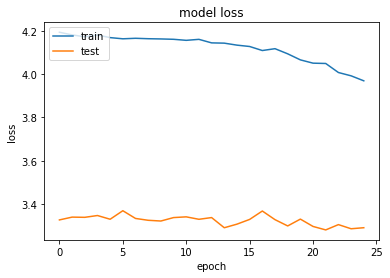

In [6]:
###############################################################################
# Training the model
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    nb_epoch=25,
    validation_split=0.1)

# list all data in history
print(history.history.keys())


# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## summarize history for accuracy
#plt.figure()
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')

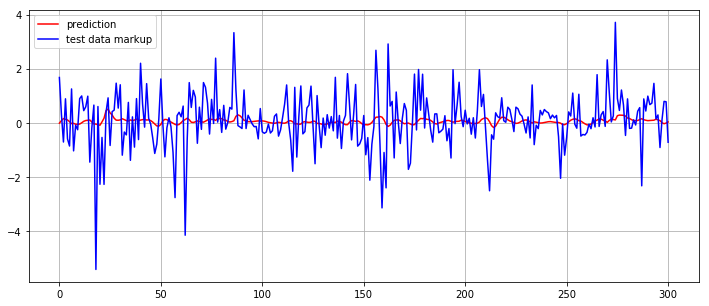

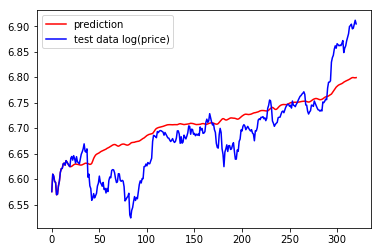

In [9]:
# [ ]:
###############################################################################
# predict on test data
p = model.predict(x_test)

# plot the predicted markup value and the actural markup value
plt.figure(figsize=(12,5))
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='test data markup')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# transform markup back into close price
pred_test_close = np.zeros(shape=(len(x_test)+seq_steps))
pred_test_close[0:seq_steps] = data['Adj Close'][-testdatacut : -testdatacut + seq_steps]
pred_test_close.shape

for i in range(len(x_test)):
    pred_test_close[seq_steps+i] = pred_test_close[seq_steps+i-1] * (1 + p[i] / 100)

# plot predict price and actural price, calculate the log value
pred_test_close_log = np.log(pred_test_close)
data_close_log = np.log(data['Adj Close'].values)

plt.figure()
plt.plot(pred_test_close_log,color='red', label='prediction')
plt.plot(data_close_log[-len(pred_test_close_log):],color='blue', label='test data log(price)')
plt.legend(loc='upper left')
plt.show()

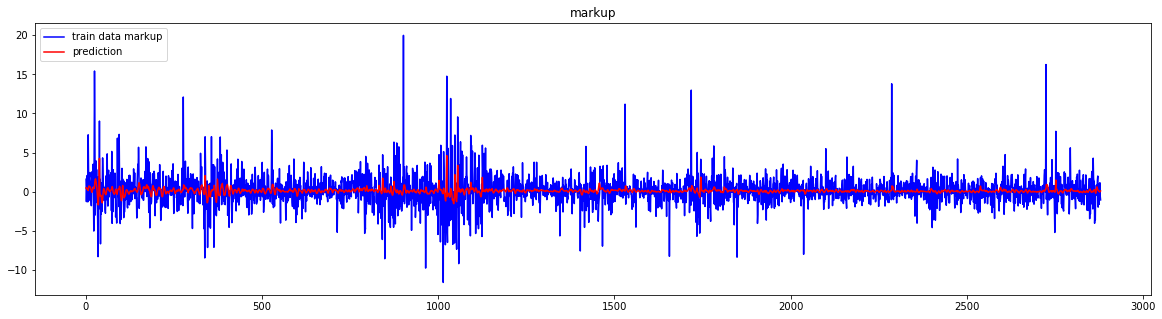

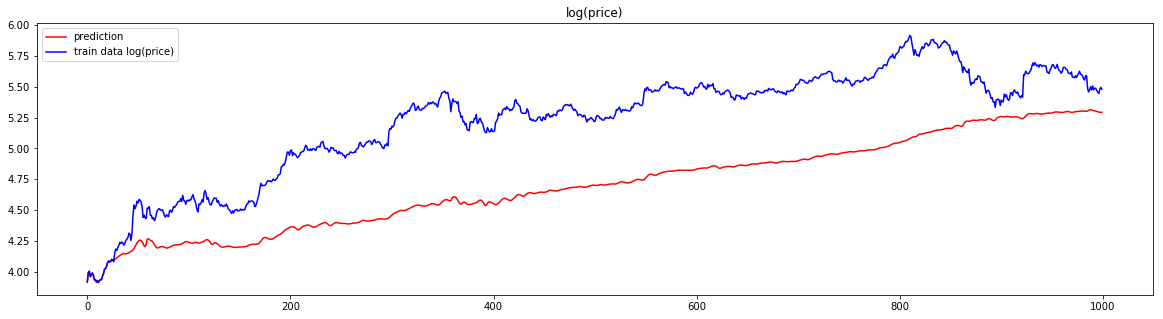

In [12]:
###############################################################################
# predict on the training data
p_train = model.predict(x_train)

# plot the predicted markup value and the actural markup value
# hard to see
plt.figure(figsize=(20,5))
plt.plot(y_train,color='blue', label='train data markup')
plt.plot(p_train,color='red', label='prediction')
plt.title('markup')
plt.legend(loc='upper left')
plt.show()

len(p_train)


# transform markup back into close price
pred_close = np.zeros(shape=(len(x_train)+seq_steps+1))
pred_close[0:seq_steps+1] = data['Adj Close'][0:seq_steps+1]
pred_close.shape

for i in range(len(x_train)):
    pred_close[seq_steps+1+i] = pred_close[seq_steps+i] * (1 + p_train[i] / 100)

## plot predict price and actural price
#plt.figure(figsize=(52,5))
#plt.plot(pred_close[0:1000],color='red', label='prediction')
#plt.plot(data['Adj Close'][0:1000],color='blue', label='y_train')

# plot predict price and actural price, calculate the log value
pred_close_log = np.log(pred_close)
data_close_log = np.log(data['Adj Close'].values)

plt.figure(figsize=(20,5))
plt.plot(pred_close_log[0:1000],color='red', label='prediction')
plt.plot(data_close_log[0:1000],color='blue', label='train data log(price)')
plt.title('log(price)')
plt.legend(loc='upper left')
plt.show()

## plot the predicted markup value
#plt.figure(figsize=(52,5))
#plt.plot(p_train[0:1000],color='red', label='prediction')
#plt.grid(True)
#plt.show()

##Step 4 - Plot the predictions!
#predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
##predictions = predict_sequences_multiple(model, x_test, 50, 50)
#len(predictions)
#len(predictions[0])
#lstm.plot_results_multiple(predictions, y_test, 50)